# <center>Actuarial Loss Prediction - Our solution<center>
## <center>Attila Gulyás and Nelvis Fornasin / Boosted Goose<center>
### <center>17.06.2021, Team Meeting Non-Life<center>

## Quick recapitulation
The aim of the competition was to predict ultimate costs on a single claim basis for worker's compensation insurance. In other words, the task was to develop an **individual claim reserving model** for IBNeR. (Incurred but not *enough* Reported)

Submissions were scored on the root mean squared error. 

# Data

In [1]:
import pandas as pd
df=pd.read_csv(filepath_or_buffer="./actuarial-loss-estimation/train.csv",
                   index_col='ClaimNumber',
                   parse_dates=['DateTimeOfAccident','DateReported'],
                   dtype={'Age':'int8','DependentChildren':'int8','DependentsOther':'int8','DaysWorkedPerWeek':'int8',
                          'Gender':'category','MaritalStatus':'category','PartTimeFullTime':'category'}
                  )
df.head(3)

,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredCalimsCost,UltimateIncurredClaimCost
ClaimNumber,,,,,,,,,,,,,,
WC8285054,2002-04-09 07:00:00+00:00,2002-07-05 00:00:00+00:00,48,M,M,0,0,500.00,F,38.0,5,LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY,1500,4748.203388
WC6982224,1999-01-07 11:00:00+00:00,1999-01-20 00:00:00+00:00,43,F,M,0,0,509.34,F,37.5,5,STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE ...,5500,6326.285819
WC5481426,1996-03-25 00:00:00+00:00,1996-04-14 00:00:00+00:00,30,M,U,0,0,709.10,F,38.0,5,CUT ON SHARP EDGE CUT LEFT THUMB,1700,2293.949087


## Initial vs Ultimate Claim Cost

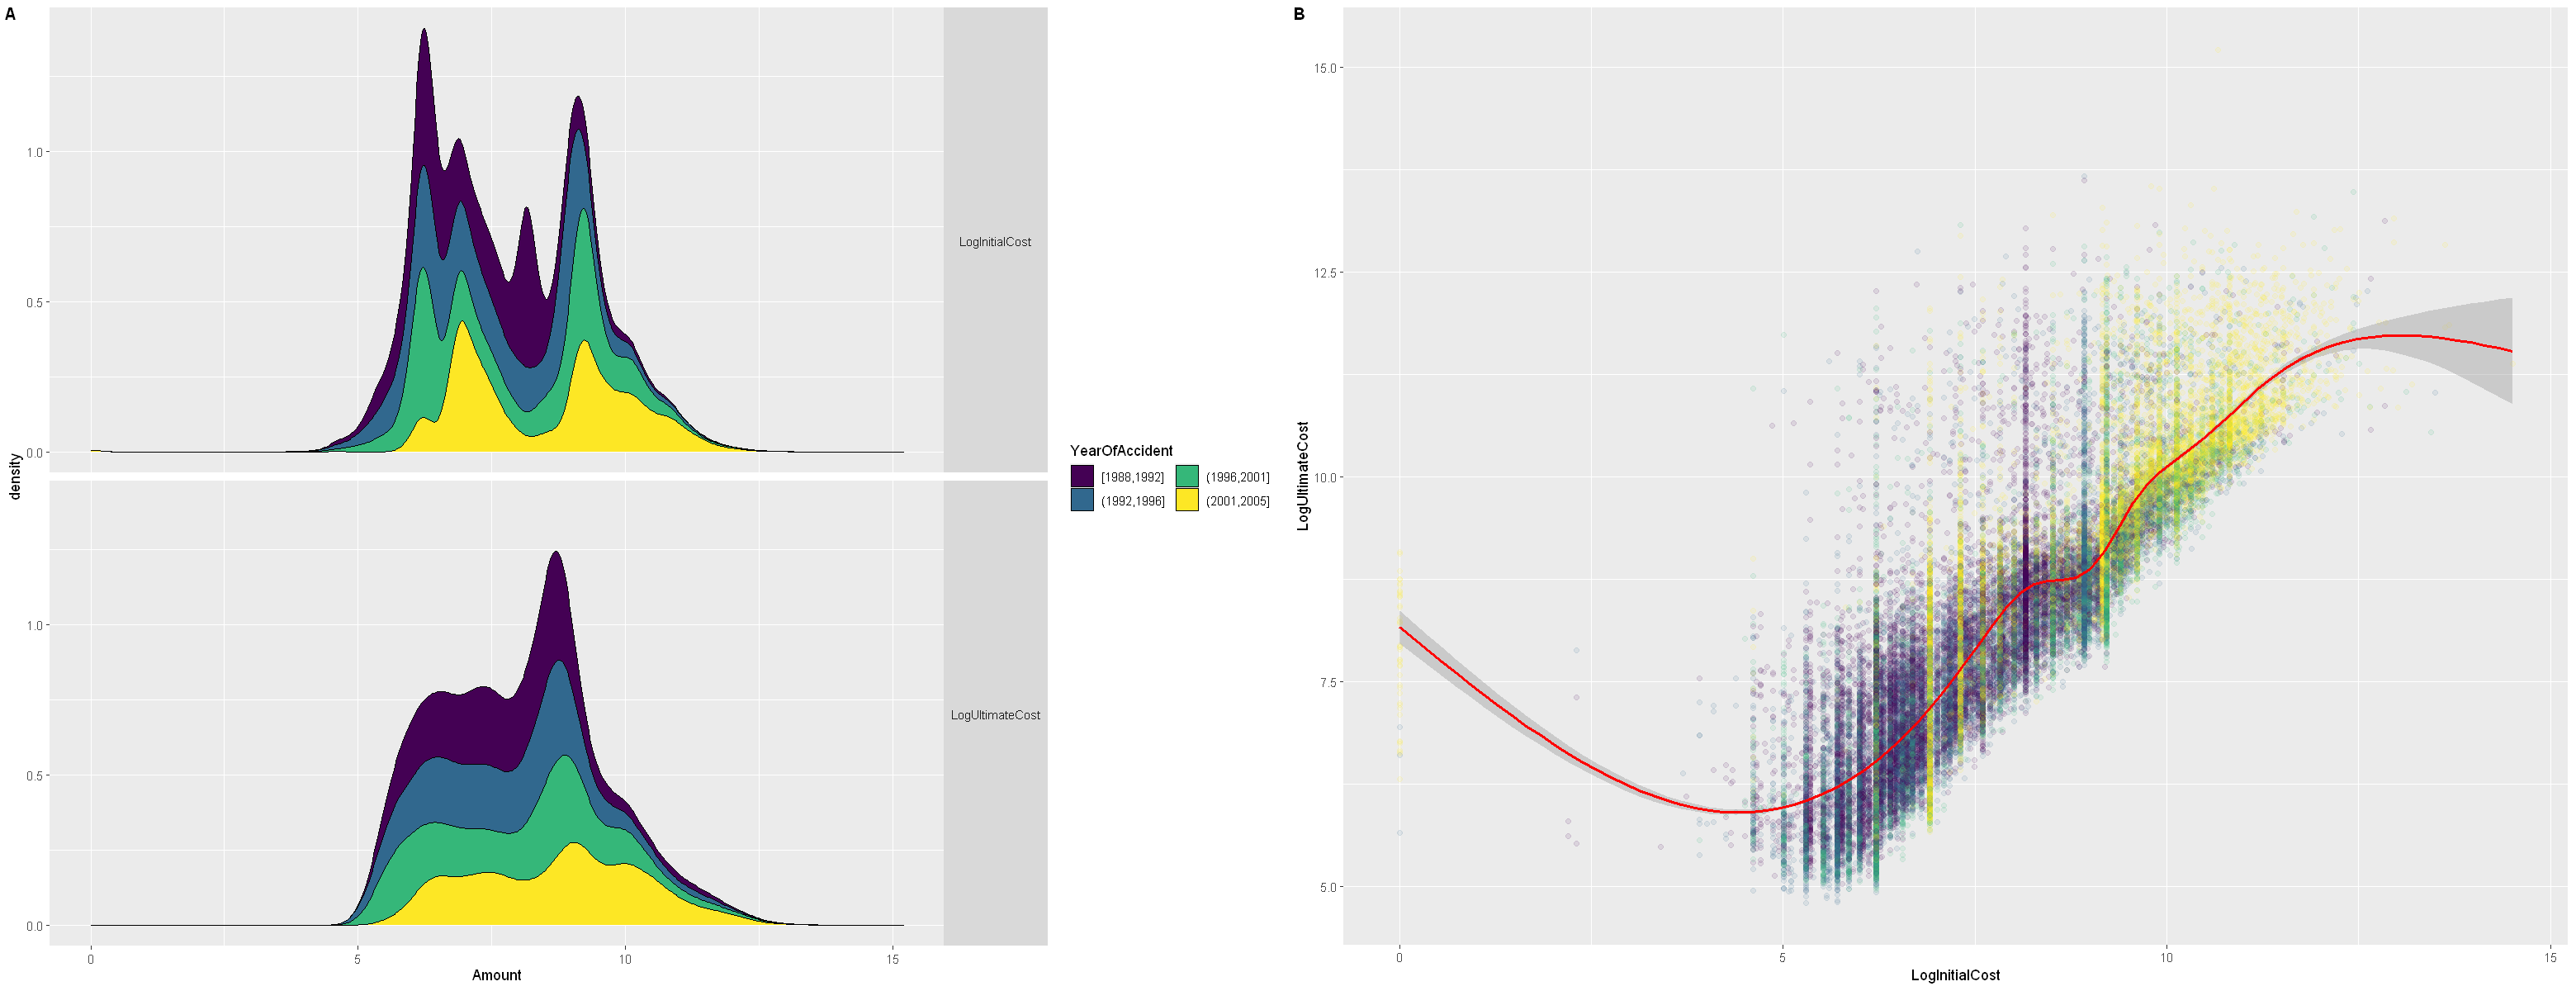

## Wordcloud of claim descriptions

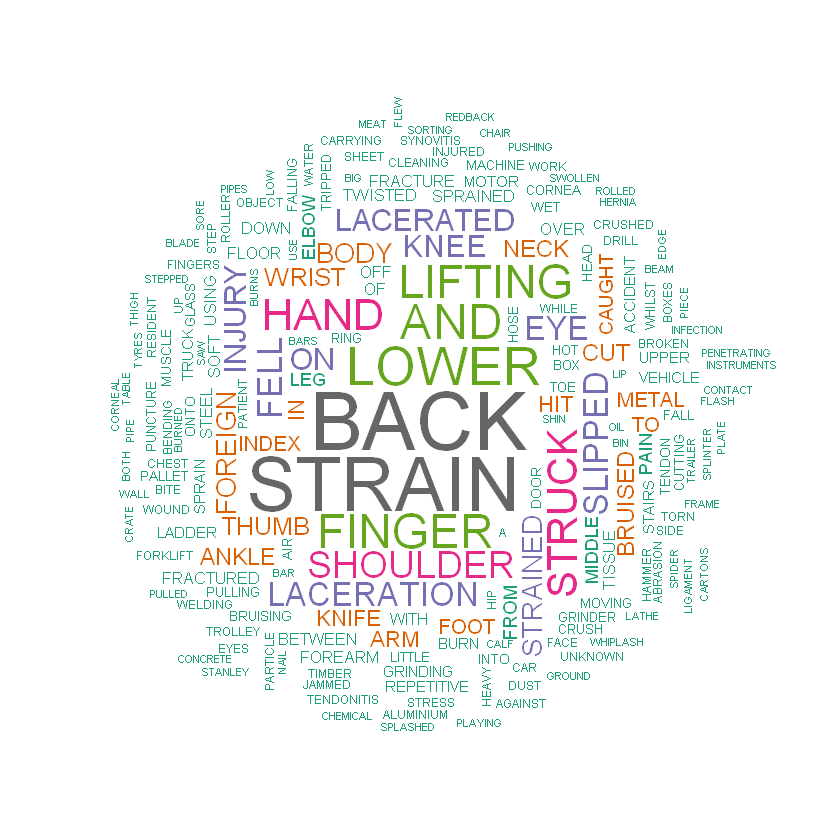

# Model

The final algorithm relied on the following ensemble techniques:
- **Boosting**: gradient boosting using xgboost
- **Bagging**: random forest as base learner
- **Voting**: custom combination of models based on insight

Besides gradient boosted trees, we have experimented with neural networks as well. Specifically, the following implementations were tried: *xgboost*, *lightgbm* and *keras*.

## What is gradient boosting?

Gradient Boosting is an ensemble learning algorithm. It adds predictors sequentially to an ensemble as follows: each new predictor is fit to the residual errors made by the previous predictor. For example, a gradient boosting algorithm consisting of 3 predictors could be described as follows:

1. Fit the 1st predictor on $X,y$. Predict $\hat{y}_1$.
2. Obtain the residuals of the 1st predictor: $y_2=y-\hat{y}_1$. Fit the 2nd predictor on $X,y_2$. Predict $\hat{y}_2$.
3. Obtain the residuals of the 2nd predictor: $y_3 = y_2 - \hat{y}_2$. Fit the 3rd predictor on $X,y_3$. Predict $\hat{y}_3$.
4. Obtain the final estimate by summing the predictions (regression): $\hat{y} = \hat{y}_1 + \hat{y}_2 + \hat{y}_3$.

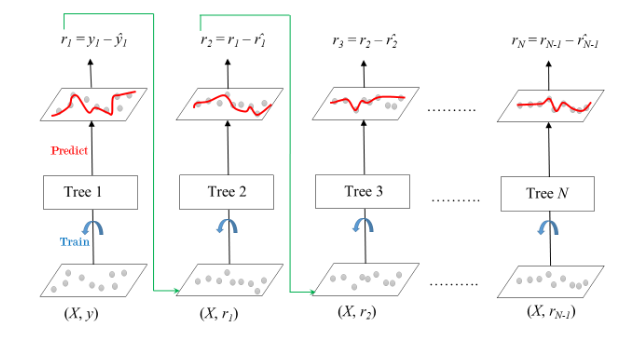

### Illustration 1: Generate test data

In [2]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

import numpy as np

X = np.linspace(start=0, stop=10, num=50).reshape(-1, 1)
y = np.square(X).flatten() + 5

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Illustration 2: Train the model

In [3]:
#Set params
max_depth = 3

In [4]:
# Fit the 1st predictor.
predictor_1 = DecisionTreeRegressor(max_depth = max_depth)
predictor_1.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3)

In [5]:
# Obtain the residuals of the 1st predictor. Fit the 2nd predictor.
y2 = y_train - predictor_1.predict(X_train)
predictor_2 = DecisionTreeRegressor(max_depth = max_depth)
predictor_2.fit(X_train, y2)

DecisionTreeRegressor(max_depth=3)

In [6]:
# Obtain the residuals of the 2nd predictor. Fit the 3rd predictor.
y3 = y2 - predictor_2.predict(X_train)
predictor_3 = DecisionTreeRegressor(max_depth = max_depth)
predictor_3.fit(X_train, y3)

DecisionTreeRegressor(max_depth=3)

### Illustration 3: Examine the results

In [7]:
#Obtain the final estimate by summing the predictions (regression)
from sklearn.metrics import mean_squared_error
y_pred = sum(predictor.predict(X_test) for predictor in (predictor_1, predictor_2, predictor_3))
mean_squared_error(y_test, y_pred)

16.496542962858477

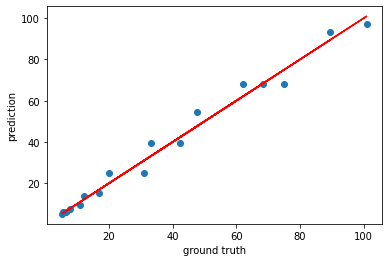

In [8]:
import matplotlib.pyplot as plt
plt.scatter(y_test,y_pred)
plt.plot(y_test, y_test, color='r')
plt.xlabel('ground truth')
plt.ylabel('prediction');

## Specifics of our model

Setting the following parameters of the model greatly improved our position on the leaderboard:
- *num_parallel_tree*: Setting this parameter to a number greater than 1 allows using random forest as base model;
- *monotone_constraints*: This can be used to enforce e.g. a positive constraint between number of dependent children and ultimate cost;
- *objective*: Changing the objective from naïve reg:squarederror to reg:gamma and reg:tweedie greatly improved results. The latter two objectives automatically use the log as link function.

## Feature importance

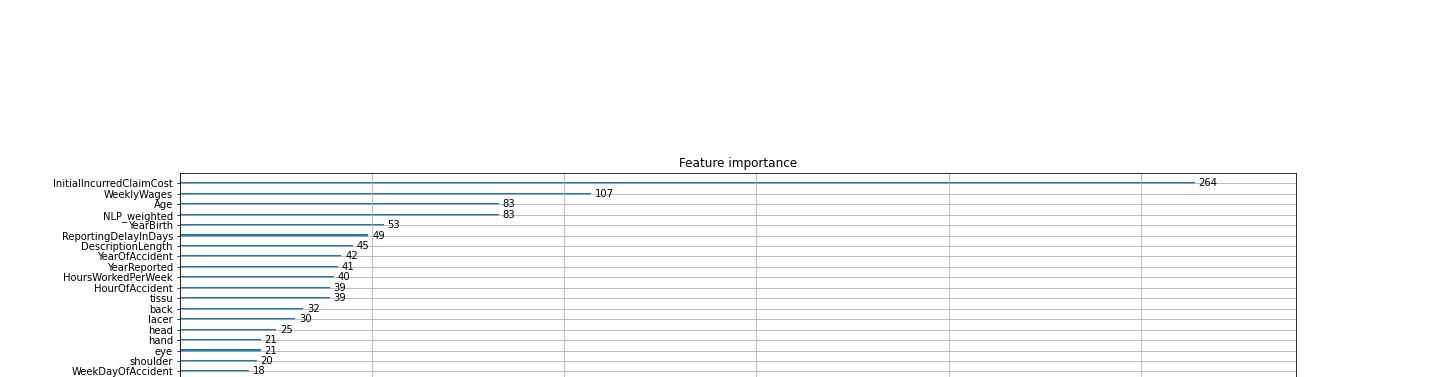

# Sandbox

In [9]:
pd.set_option("display.max_columns", 500)
preprocessed = pd.read_csv(filepath_or_buffer="./actuarial-loss-estimation/preprocessed.csv",
                           index_col='ClaimNumber',
                           parse_dates=['DateTimeOfAccident','DateReported'],
                           dtype={'Age':'int8','DependentChildren':'int8','DependentsOther':'int8','DaysWorkedPerWeek':'int8',
                                  'Gender':'category','MaritalStatus':'category','PartTimeFullTime':'category'},
                           nrows=5000
                  ).drop(columns=["ohe_Gender_M", "ohe_PartTimeFullTime_P", "ohe_MaritalStatus_M"])

In [10]:
preprocessed.head(3)

,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredClaimCost,UltimateIncurredClaimCost,abdomin,ankl,arm,back,big toe,blood,bone,breast,calf,carpel tunnel,cheek,chest,chin,coccyx,collar bone,cornea,corneal,dental,ear,elbow,epicondyl,eye,eyelid,face,facial,finger,fingernail,foot,forearm,forefing,forehead,groin,hair,hand,head,heel,hip,inguin,jaw,knee,leg,ligament,lip,meniscus,mouth,muscl,muscular,nail,neck,nose,palm,patella,radius,scalp,scapula,shin,shoulder,skin,skull,sole,spine,sternum,stomach,tendon,thigh,thorac,throat,thumb,tibia,tissu,toe,tooth,torso,vein,vertebra,wrist,abras,allerg,allergi,amput,arthriti,break,broke,broken,bruis,burn,concuss,crush,cut,depress,disord,fractur,grind,headach,hernia,infect,inflamm,lacer,mental,multipl,nausea,punctur,sore,sprain,strain,stung,tear,torn,twist,ulcer,victimis,whiplash,abscess,aluminium,anxieti,axe,bang,bear,beast,bee,bend,bicycl,bite,blade,camel,car,catch,chainsaw,chemic,climb,cow,door,drop,explod,explos,fall,fibreglass,foreign,fragment,glass,grab,granit,grinder,hammer,hit,hors,insect,iron,jigsaw,jump,knife,ladder,lamb,lift,limeston,log,machin,metal,mirror,motor,motorcycl,mutton,overwork,pick,pig,pull,razor,redback,rock,run,saw,sharp,sheep,slip,slipperi,snake,spider,stair,steel,stove,stress,strike,timber,toxic,trip,truck,vehicl,walk,weld,wooden,YearOfAccident,WeekDayOfAccident,HourOfAccident,YearReported,YearBirth,ReportingDelay,ReportingDelayInDays,DescriptionLength,NewBusiness,OldBusiness,CoreWorkingHour,ohe_Gender_F,ohe_PartTimeFullTime_F,ohe_MaritalStatus_S,ohe_MaritalStatus_U,SLIPPED USING LATHE IN EYE CORNEA,REDBACK SPIDER BITE RIGHT FOOT RIGHT FRACTURE,LIFTING TYRES LOWER BACK STRAIN,LIFTING BACK STRAIN LOWER BACK STRAIN,FELL DOWN STAIRS BACK SPRAIN,USING AIR HOSE STRAIN RIGHT KNEE RIGHT,FRACTURED LEFT WRIST FRACTURE LEFT MIDDLE FINGER,NLP_weighted
ClaimNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
WC8285054,2002-04-09 07:00:00+00:00,2002-07-05 00:00:00+00:00,48,M,M,0,0,500.00,F,38.0,5,LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY,1500,4748.203388,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2002,1,7,2002,1954,86 days 17:00:00,86,8,1,0,1,0,1,0,0,0,0,0,0,0,0,0,36.0
WC6982224,1999-01-07 11:00:00+00:00,1999-01-20 00:00:00+00:00,43,F,M,0,0,509.34,F,37.5,5,STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE ...,5500,6326.285819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

## Hyperoptimization

In [17]:
import xgboost as xgb
from ray import tune

In [18]:
# see https://xgboost.readthedocs.io/en/latest/parameter.html

search_space = {
    'objective':'reg:tweedie', #alternatives: reg:squarederror, reg:gamma
    'eval_metric':'rmse', #this is fixed
    'eta': tune.uniform(1e-2, 2e-1), #for gradient descent
    'max_depth': tune.randint(3, 6), #tree depth
    'min_child_weight': tune.randint(4, 8), #minimal data points per leaf
    'subsample': tune.uniform(0.5, 0.8), #compare with 'batch' for neural networks
    'colsample_bytree' : tune.uniform(0.8,0.99), #subset features by tree
    'colsample_bylevel': tune.uniform(0.8,1.0), #subset features by depth level
    'colsample_bynode' : tune.uniform(0.6,0.8), #subset features by node split
    'gamma' : tune.loguniform(1e+1, 1e+5), #regularize
    'alpha' : tune.loguniform(1e+0, 5e+4), #regularize
    'tweedie_variance_power' : tune.uniform(1.1,1.6) #tweedie specific
    }

In [20]:
m_constraints = {feature:'0' for feature in preprocessed.columns}

#positive monotonity
for feature in ['InitialIncurredClaimCost','DependentChildren','DependentsOther','WeeklyWages','HoursWorkedPerWeek','DaysWorkedPerWeek']:
    m_constraints[feature] = '1'
    
monotone_constraints = '({constraints})'.format(constraints = ', '.join(m_constraints.values()))

In [34]:
X_xgb, y = preprocessed.drop(columns=['UltimateIncurredClaimCost']),preprocessed['UltimateIncurredClaimCost']
X_xgb = X_xgb.select_dtypes(include='number',exclude=['timedelta','datetime'])

def train_xgb_cv(config: dict):
    
    data=xgb.DMatrix(X_xgb, label=y)
    params = {'objective':config['objective'],
              'eval_metric':config['eval_metric'],
              'eta': config['eta'],
              'max_depth':config['max_depth'],
              'subsample':config['subsample'],
              'min_child_weight':config['min_child_weight'],
              'colsample_bylevel': config['colsample_bylevel'],
              'colsample_bynode' : config['colsample_bynode'],
              'colsample_bytree': config['colsample_bytree'],
              'gamma' : config['gamma'],
              'alpha' : config['alpha'],
              'monotone_constraints' : monotone_constraints,
              'tweedie_variance_power' : config['tweedie_variance_power']
              }
    
    results = xgb.cv(config,data,verbose_eval=False,num_boost_round=20,early_stopping_rounds=5,nfold=2,as_pandas=False)
    
    tune.report(rmse_mean=results['test-rmse-mean'][-1])

In [27]:
import ray
ray.shutdown()

In [29]:
analysis = tune.run(train_xgb_cv,config=search_space,metric='rmse_mean',mode="min",num_samples=6,verbose=0,
                    keep_checkpoints_num=1, checkpoint_score_attr="rmse_mean")

2021-06-15 17:11:17,064	INFO tune.py:555 -- Total run time: 46.19 seconds (44.90 seconds for the tuning loop).
(pid=10816) Windows fatal exception: access violation
(pid=10816) 


In [ ]:
params = analysis.best_config
params

In [35]:
#params = analysis.best_config.copy()
#params['num_parallel_tree'] = 1 #if you uncomment this and run the following lines, you better not have plans for the next 2 hrs

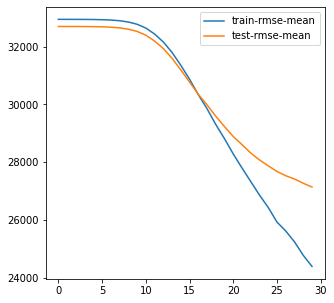

In [36]:
xgb_cv_results = xgb.cv(dtrain=xgb.DMatrix(X_xgb, label=y), params=params, nfold=3,num_boost_round=30,early_stopping_rounds=20,metrics='rmse',as_pandas=True)
plt.rcParams['figure.figsize'] = [5, 5]
_ = xgb_cv_results.filter(regex='mean').plot()

In [37]:
best_xgb = xgb.train(params=params, dtrain=xgb.DMatrix(X_xgb, label=y), num_boost_round=len(xgb_cv_results))

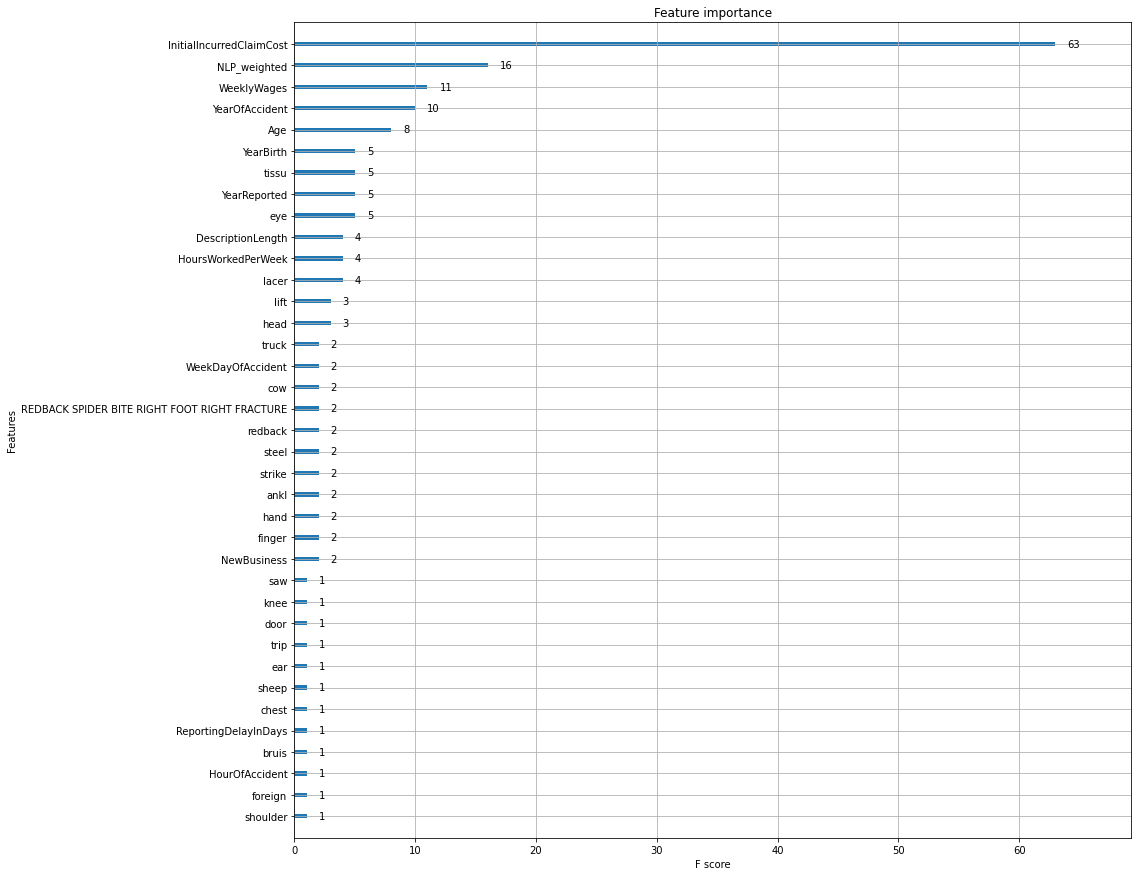

In [38]:
# how many times did we split on each feature?

plt.rcParams['figure.figsize'] = [15, 15]
xgb.plot_importance(best_xgb)
plt.show()

# Conclusions

The challenge was great fun!

Lessons learned:
- Feature engineering was more important than hyperparameter tuning;
- Our machines learnt but it was time-consuming to teach them!;
- Stacking seemed to result in overfitting;
- Neural networks are not a cure-all;

Thank you for your attention!